# Attribute 1

In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb

df = pd.read_csv('230611_GMM.csv')
# Convert to datetime object
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
# Convert to Unix timestamp
df['unix_timestamp'] = df['deviceTime'].apply(lambda x: x.timestamp())

# initialize OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the data
encoded = encoder.fit_transform(df[['label']]).toarray()

# create new columns in the original dataframe with the encoded values
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['label']))
df = pd.concat([df, encoded_df], axis=1)

df = df.drop(['date', 'label', 'vehicleId', 'ending', 'starting', 'gnssPDOP', 'gnssHDOP', 'Model', 'Brand', 
              'Engine CC', 'BDM', 'BTM'], axis = 1, errors = 'ignore')

from sklearn.preprocessing import MinMaxScaler

# Select only the columns that have numeric data types and exclude target
numeric_cols = df.select_dtypes(include=['float', 'int']).columns
numeric_cols = numeric_cols.drop('fuel_diff')

# Apply MinMaxScaler only on the numeric columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# The object columns remain unchanged

# Split the data into training, validation, and test sets
val_mask = df_scaled['new_vehicle_id'].isin(['v1', 'v7', 'v10', 'v5', 'v17'])
test_mask = df_scaled['new_vehicle_id'].isin(['v3', 'v8', 'v28', 'v32', 'v2'])
train_mask = ~df_scaled['new_vehicle_id'].isin(np.concatenate((val_mask, test_mask)))
X_train = df_scaled.loc[train_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff' ,'fuel_level'])
y_train = df_scaled.loc[train_mask, 'fuel_diff']
X_val = df_scaled.loc[val_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff', 'fuel_level'])
y_val = df_scaled.loc[val_mask, 'fuel_diff']
X_test = df_scaled.loc[test_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff','fuel_level'])
y_test = df_scaled.loc[test_mask, 'fuel_diff']

/tmp/ipykernel_1683/2930054720.py:9: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('230611_GMM.csv')


In [3]:
X_train.columns

Index(['speed_generate', 'batteryVoltage', 'altitude', 'heading', 'lat', 'lon',
       'axisX', 'axisY', 'axisZ', 'distance (km)', 'Fuel Capacity (L)_x',
       'Engine CC', 'BDM', 'BTM', 'unix_timestamp', 'label_abnormal',
       'label_normal', 'label_refuel'],
      dtype='object')

In [17]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(params):
    model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

# Define the search space for hyperparameters
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 10)
}

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = {k: v for k, v in best.items() if k in space}

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **best_params)
final_model.fit(X_train, y_train)


100%|███████████████████████████████████████████████| 100/100 [02:28<00:00,  1.48s/trial, best loss: 1.4687287450247364]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8827624794845477, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=3.455994760039037, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.281103081132881, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [19]:
# Make predictions using the trained model
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate the training and test errors
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}')
print(f'Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}')

Train MSE: 12.7606, MAE: 0.5455, RMSE: 3.5722, R2: 0.6384
Validation MSE: 9.0106, MAE: 0.3940, RMSE: 3.0018, R2: 0.6785
Test MSE: 16.1656, MAE: 0.6224, RMSE: 4.0207, R2: 0.6485


# Attribute 2

In [6]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('230611_GMM.csv')
# Convert to datetime object
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
# Convert to Unix timestamp
df['unix_timestamp'] = df['deviceTime'].apply(lambda x: x.timestamp())

# initialize OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the data
encoded = encoder.fit_transform(df[['label']]).toarray()

# create new columns in the original dataframe with the encoded values
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['label']))
df = pd.concat([df, encoded_df], axis=1)

df = df.drop(['date', 'label', 'vehicleId', 'ending', 'starting', 'gnssPDOP', 'gnssHDOP', 'Model', 'Brand', 
              'Engine CC', 'BDM', 'BTM'], axis = 1, errors = 'ignore')

from sklearn.preprocessing import MinMaxScaler

# Select only the columns that have numeric data types
numeric_cols = df.select_dtypes(include=['float', 'int']).columns
numeric_cols = numeric_cols.drop('fuel_diff')

# Apply MinMaxScaler only on the numeric columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# The object columns remain unchanged

# Split the data into training, validation, and test sets
val_mask = df_scaled['new_vehicle_id'].isin(['v1', 'v7', 'v10', 'v5', 'v17'])
test_mask = df_scaled['new_vehicle_id'].isin(['v3', 'v8', 'v28', 'v32', 'v2'])
train_mask = ~df_scaled['new_vehicle_id'].isin(np.concatenate((val_mask, test_mask)))
X_train = df_scaled.loc[train_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff' ,'fuel_level', 'batteryVoltage', 'axisX', 'axisY', 'axisZ'])
y_train = df_scaled.loc[train_mask, 'fuel_diff']
X_val = df_scaled.loc[val_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff', 'fuel_level', 'batteryVoltage', 'axisX', 'axisY', 'axisZ'])
y_val = df_scaled.loc[val_mask, 'fuel_diff']
X_test = df_scaled.loc[test_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff','fuel_level', 'batteryVoltage', 'axisX', 'axisY', 'axisZ'])
y_test = df_scaled.loc[test_mask, 'fuel_diff']

/tmp/ipykernel_1683/1246710310.py:8: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('230611_GMM.csv')


In [23]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(params):
    model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

# Define the search space for hyperparameters
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 10)
}

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = {k: v for k, v in best.items() if k in space}

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **best_params)
final_model.fit(X_train, y_train)


100%|███████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/trial, best loss: 1.7867033669976067]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8906520268295383, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=8.577017164573276, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2965956901519447, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
# Make predictions using the trained model
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate the training and test errors
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}')
print(f'Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}')

Train MSE: 14.0386, MAE: 0.5531, RMSE: 3.7468, R2: 0.6022
Validation MSE: 9.7936, MAE: 0.4081, RMSE: 3.1295, R2: 0.6505
Test MSE: 16.7971, MAE: 0.6226, RMSE: 4.0984, R2: 0.6348


# Swap A1

In [27]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('230611_GMM.csv')
# Convert to datetime object
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
# Convert to Unix timestamp
df['unix_timestamp'] = df['deviceTime'].apply(lambda x: x.timestamp())

# initialize OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the data
encoded = encoder.fit_transform(df[['label']]).toarray()

# create new columns in the original dataframe with the encoded values
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['label']))
df = pd.concat([df, encoded_df], axis=1)

df = df.drop(['date', 'label', 'vehicleId', 'ending', 'starting', 'gnssPDOP', 'gnssHDOP'], axis = 1)

from sklearn.preprocessing import MinMaxScaler

# Select only the columns that have numeric data types
numeric_cols = df.select_dtypes(include=['float', 'int']).columns
numeric_cols = numeric_cols.drop('fuel_diff')

# Apply MinMaxScaler only on the numeric columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# The object columns remain unchanged

# Split the data into training, validation, and test sets
test_mask = df_scaled['new_vehicle_id'].isin(['v1', 'v7', 'v10', 'v5', 'v17'])
val_mask = df_scaled['new_vehicle_id'].isin(['v3', 'v8', 'v28', 'v32', 'v2'])
train_mask = ~df_scaled['new_vehicle_id'].isin(np.concatenate((val_mask, test_mask)))
X_train = df_scaled.loc[train_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff' ,'fuel_level'])
y_train = df_scaled.loc[train_mask, 'fuel_diff']
X_val = df_scaled.loc[val_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff', 'fuel_level'])
y_val = df_scaled.loc[val_mask, 'fuel_diff']
X_test = df_scaled.loc[test_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff','fuel_level'])
y_test = df_scaled.loc[test_mask, 'fuel_diff']

In [28]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(params):
    model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

# Define the search space for hyperparameters
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 10)
}

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = {k: v for k, v in best.items() if k in space}

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **best_params)
final_model.fit(X_train, y_train)


100%|████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/trial, best loss: 2.064574943441356]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9566355581801301, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.815664561460531, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2500324206641883, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [29]:
# Make predictions using the trained model
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate the training and test errors
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}')
print(f'Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}')

Train MSE: 12.7810, MAE: 0.5352, RMSE: 3.5751, R2: 0.6379
Validation MSE: 14.7099, MAE: 0.5968, RMSE: 3.8354, R2: 0.6801
Test MSE: 9.2237, MAE: 0.3907, RMSE: 3.0371, R2: 0.6709


# Swap A2

In [31]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('230611_GMM.csv')
# Convert to datetime object
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
# Convert to Unix timestamp
df['unix_timestamp'] = df['deviceTime'].apply(lambda x: x.timestamp())

# initialize OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the data
encoded = encoder.fit_transform(df[['label']]).toarray()

# create new columns in the original dataframe with the encoded values
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['label']))
df = pd.concat([df, encoded_df], axis=1)

df = df.drop(['date', 'label', 'vehicleId', 'ending', 'starting', 'gnssPDOP', 'gnssHDOP'], axis = 1)

from sklearn.preprocessing import MinMaxScaler

# Select only the columns that have numeric data types
numeric_cols = df.select_dtypes(include=['float', 'int']).columns
numeric_cols = numeric_cols.drop('fuel_diff')

# Apply MinMaxScaler only on the numeric columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# The object columns remain unchanged

# Split the data into training, validation, and test sets
test_mask = df_scaled['new_vehicle_id'].isin(['v1', 'v7', 'v10', 'v5', 'v17'])
val_mask = df_scaled['new_vehicle_id'].isin(['v3', 'v8', 'v28', 'v32', 'v2'])
train_mask = ~df_scaled['new_vehicle_id'].isin(np.concatenate((val_mask, test_mask)))
X_train = df_scaled.loc[train_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff' ,'fuel_level', 'batteryVoltage', 'axisX', 'axisY', 'axisZ'])
y_train = df_scaled.loc[train_mask, 'fuel_diff']
X_val = df_scaled.loc[val_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff', 'fuel_level', 'batteryVoltage', 'axisX', 'axisY', 'axisZ'])
y_val = df_scaled.loc[val_mask, 'fuel_diff']
X_test = df_scaled.loc[test_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff','fuel_level', 'batteryVoltage', 'axisX', 'axisY', 'axisZ'])
y_test = df_scaled.loc[test_mask, 'fuel_diff']

In [32]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

def objective(params):
    model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    return rmse

# Define the search space for hyperparameters
space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 10)
}

# Run the hyperparameter optimization
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
best_params = {k: v for k, v in best.items() if k in space}

# Train the final model with the best hyperparameters
final_model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **best_params)
final_model.fit(X_train, y_train)


100%|████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/trial, best loss: 2.098316078499158]


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8284135300910197, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1.3112939009085225, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2913449521771427, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [33]:
# Make predictions using the trained model
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)
y_test_pred = final_model.predict(X_test)

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Calculate the training and test errors
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R2: {train_r2:.4f}')
print(f'Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, RMSE: {val_rmse:.4f}, R2: {val_r2:.4f}')
print(f'Test MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}')

Train MSE: 13.1673, MAE: 0.5394, RMSE: 3.6287, R2: 0.6269
Validation MSE: 14.3947, MAE: 0.5942, RMSE: 3.7940, R2: 0.6870
Test MSE: 9.0952, MAE: 0.3950, RMSE: 3.0158, R2: 0.6755


In [2]:
pip install --extra-index-url=https://pypi.nvidia.com cudf-cu12 cuml-cu12


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
  Using cached cudf-cu12-23.6.1.tar.gz (6.8 kB)
    ERROR: Command errored out with exit status 1:
     command: /usr/bin/python3 -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-x506_z9l/cudf-cu12/setup.py'"'"'; __file__='"'"'/tmp/pip-install-x506_z9l/cudf-cu12/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-install-x506_z9l/cudf-cu12/pip-egg-info
         cwd: /tmp/pip-install-x506_z9l/cudf-cu12/
    Complete output (15 lines):
    Traceback (most recent call last):
      File "<string>", line 1, in <module>
      File "/tmp/pip-install-x506_z9l/cudf-cu12/setup.py", line 137, in <module>
        raise RuntimeError(open("ERROR.txt", "r").read())
    RuntimeError:
    #########################################################################

# Correlation

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('230611_GMM.csv')
# Convert to datetime object
df['deviceTime'] = pd.to_datetime(df['deviceTime'])
# Convert to Unix timestamp
df['unix_timestamp'] = df['deviceTime'].apply(lambda x: x.timestamp())

# initialize OneHotEncoder
encoder = OneHotEncoder()

# fit and transform the data
encoded = encoder.fit_transform(df[['label']]).toarray()

# create new columns in the original dataframe with the encoded values
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['label']))
df = pd.concat([df, encoded_df], axis=1)

df = df.drop(['date', 'label', 'vehicleId', 'ending', 'starting', 'Brand', 'Model'], 
             axis = 1, errors = 'ignore')

from sklearn.preprocessing import MinMaxScaler

# Select only the columns that have numeric data types and exclude target
numeric_cols = df.select_dtypes(include=['float', 'int']).columns
numeric_cols = numeric_cols.drop('fuel_diff')

# Apply MinMaxScaler only on the numeric columns
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

# The object columns remain unchanged

# Split the data into training, validation, and test sets
val_mask = df_scaled['new_vehicle_id'].isin(['v1', 'v7', 'v10', 'v5', 'v17'])
test_mask = df_scaled['new_vehicle_id'].isin(['v3', 'v8', 'v28', 'v32', 'v2'])
train_mask = ~df_scaled['new_vehicle_id'].isin(np.concatenate((val_mask, test_mask)))
X_train = df_scaled.loc[train_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff' ,'fuel_level'])
y_train = df_scaled.loc[train_mask, 'fuel_diff']
X_val = df_scaled.loc[val_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff', 'fuel_level'])
y_val = df_scaled.loc[val_mask, 'fuel_diff']
X_test = df_scaled.loc[test_mask, :].drop(columns=['new_vehicle_id', 'deviceTime', 'fuel_diff','fuel_level'])
y_test = df_scaled.loc[test_mask, 'fuel_diff']

/tmp/ipykernel_1484/3784183299.py:8: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('230611_GMM.csv')


In [2]:
param = {'learning_rate': 0.28, 'max_depth': 6, 'colsample_bytree':0.96, 'gamma': 4.82}

In [3]:
import xgboost as xgb
# Train the final model with the best hyperparameters
XGB = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, **param)
XGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.96, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=4.82, gpu_id=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.28, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

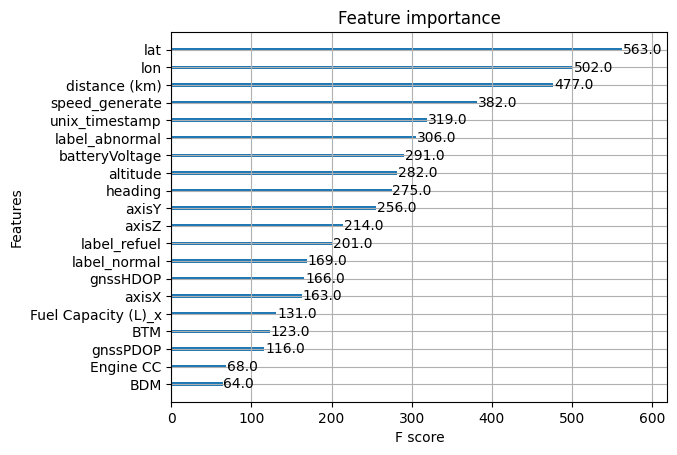

In [7]:
import matplotlib.pyplot as plt
# Plot feature importance
xgb.plot_importance(XGB)
plt.show()

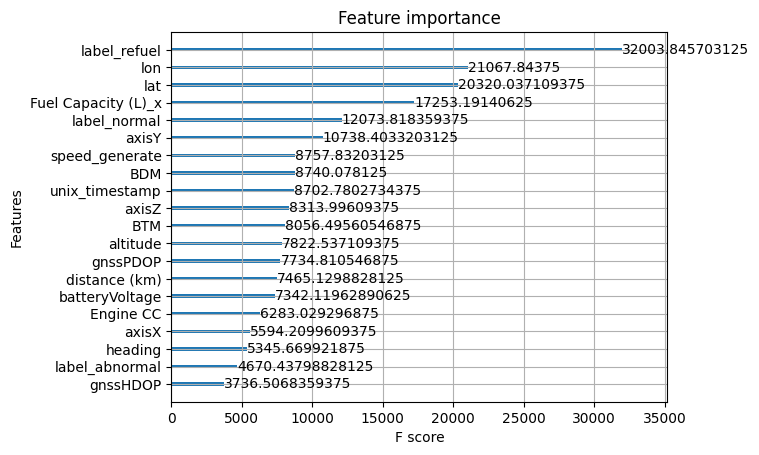

In [4]:
import matplotlib.pyplot as plt
# Plot feature importance
xgb.plot_importance(XGB, importance_type='gain')
plt.show()